1.1 Exploratory Data Analysis (EDA)

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [108]:
x_data= np.load('./data/train_images.npy')
print("Training (meta) data: ", x_data.shape)
y_data = pd.read_csv('./data/train_labels.csv', delimiter=',')

x_test = np.load('./data/test_images.npy')
print("Test (meta) data: ", x_test.shape)

# Show first rows of data

y_data.head(10)

Training (meta) data:  (60000, 28, 28)
Test (meta) data:  (10000, 28, 28)


,label
0,9
1,0
2,0
3,3
4,0
5,2
6,7
7,2
8,5
9,5


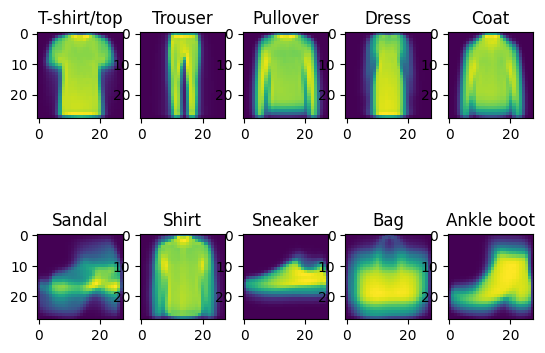

In [109]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

figure, axis = plt.subplots(2, 5)
k = 0
for i in range(2):
    for j in range(5):
        axis[i,j].imshow(x_train[y_data.label.values == k,...].mean(axis=0))
        axis[i,j].grid(False)
        axis[i,j].set_title(class_names[k])
        k += 1

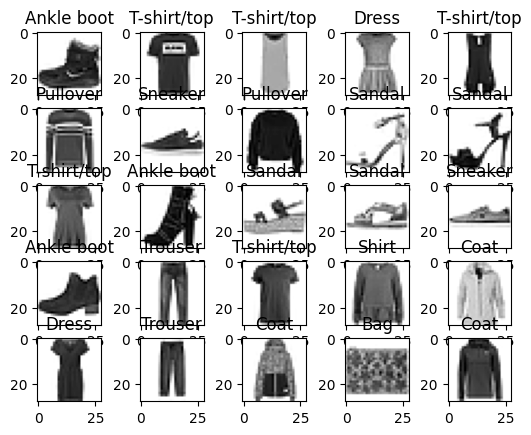

In [110]:
figure, axis = plt.subplots(5, 5)
k = 0
for i in range(5):
    for j in range(5):
        axis[i,j].imshow(x_data[k], cmap=plt.cm.binary)
        axis[i,j].grid(False)
        axis[i,j].set_title(class_names[y_data.label[k]])
        k += 1
plt.show()

Histograma de distribución de clases: las clases son equiprobables.

(array([6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000.,
        6000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

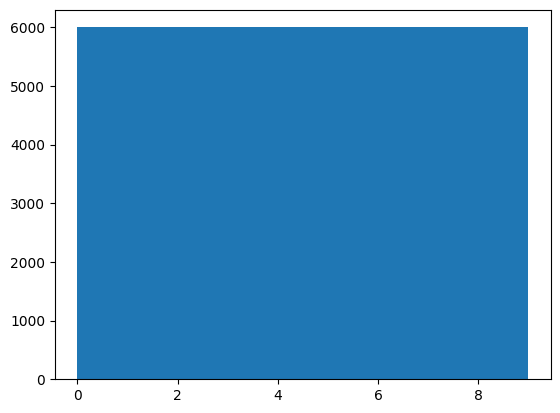

In [111]:
plt.hist(y_data['label']) 

Data splitting: train/validation datasets:
Training data — used for training the model
Validation data — used for tuning the hyperparameters and evaluate the models

In [117]:
# 20% del dataset para validación
validation = 0.20
N_validation_split = int(x_data.shape[0]*(1-validation))
# Training Set
x_train = x_data[:N_validation_split]
y_train = y_data[:N_validation_split]

# Cross Validation Set
x_val = x_data[N_validation_split:]
y_val = y_data[N_validation_split:]
print('Training set data:', x_train.shape)
print('Training labels:', y_train.shape)
print()
print('CV set data:', x_val.shape)
print('CV labels:', y_val.shape)

Training set data: (48000, 28, 28)
Training labels: (48000, 1)

CV set data: (12000, 28, 28)
CV labels: (12000, 1)


Data normalization

In [124]:
from sklearn.preprocessing import StandardScaler

In [125]:
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

#Normalizing the data
#sc = StandardScaler()
#x_train = sc.fit_transform(x_train.values)

MLP: let's start!

In [216]:
from keras.models import Sequential, load_model, Model
from keras import regularizers
from keras.layers import Dense, BatchNormalization, Dropout, Flatten, Activation
from keras import optimizers
from keras.metrics import SensitivityAtSpecificity
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
import keras.backend as K
import datetime

One-hot encoding

In [157]:
y_train_categorical = np_utils.to_categorical(y_train['label'])
y_val_categorical = np_utils.to_categorical(y_val)
print(y_train_categorical.shape)
for i in range(10):
    print(y_train['label'][i], y_train_categorical[i])

(48000, 10)
9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


The neural network needs to start with some weights and then iteratively update them to better values. The term kernel_initializer is a fancy term for which statistical distribution or function to use for initialising the weights. In case of statistical distribution, the library will generate numbers from that statistical distribution and use as starting weights.
https://datascience.stackexchange.com/questions/37378/what-are-kernel-initializers-and-what-is-their-significance 

A single layer just to check out how it behaves

In [158]:
K.clear_session()

output_size = 10
# Creo el modelo
model_single_layer = Sequential()
model_single_layer.add(Flatten(input_shape=x_train.shape[1:]))
model_single_layer.add(Dense(output_size, kernel_initializer='normal', name='Output'))
model_single_layer.add(Activation('softmax'))
model_single_layer.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [159]:
# Compilo el modelo
lr = 0.001
SGD = optimizers.Adam(lr=lr)
model_single_layer.compile(loss = 'categorical_crossentropy', optimizer=SGD, metrics=['accuracy'])

C:\Users\Facu Molina\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Callback for early stopping

In [226]:
callback = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.001,
    patience=10,
    verbose=2,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=30,
)

Accuracy of model previous to training

In [177]:
score = model_single_layer.evaluate(x_val, y_val_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])


loss:  0.5974925756454468
accuracy:  0.7973333597183228


Let's train this single layer

In [178]:
batch_size = 1000
model_single_layer.fit(x_train, 
                       y_train_categorical,
                       epochs=500, batch_size=batch_size, 
                       verbose=1, 
                       validation_data = (x_val, y_val_categorical),
                       callbacks=[callback],
                      )

Epoch 1/500
48/48 [==============================] - 1s 15ms/step - loss: 0.6006 - accuracy: 0.7984 - val_loss: 0.5971 - val_accuracy: 0.7973
Epoch 2/500
48/48 [==============================] - 1s 19ms/step - loss: 0.6002 - accuracy: 0.7987 - val_loss: 0.5968 - val_accuracy: 0.7974
Epoch 3/500
48/48 [==============================] - 1s 18ms/step - loss: 0.5998 - accuracy: 0.7988 - val_loss: 0.5964 - val_accuracy: 0.7976
Epoch 4/500
48/48 [==============================] - 1s 16ms/step - loss: 0.5994 - accuracy: 0.7989 - val_loss: 0.5961 - val_accuracy: 0.7976
Epoch 5/500
48/48 [==============================] - 1s 15ms/step - loss: 0.5991 - accuracy: 0.7990 - val_loss: 0.5958 - val_accuracy: 0.7983
Epoch 6/500
48/48 [==============================] - 1s 16ms/step - loss: 0.5987 - accuracy: 0.7992 - val_loss: 0.5954 - val_accuracy: 0.7978
Epoch 7/500
48/48 [==============================] - 1s 16ms/step - loss: 0.5983 - accuracy: 0.7993 - val_loss: 0.5950 - val_accuracy: 0.7981
Epoch 

One hidden layer model

In [184]:
K.clear_session()
def two_layer_model(lr=0.001, decay=0, hidden_units=500, activation='relu'):
    output_size = 10
    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(hidden_units, activation=activation, kernel_initializer='normal', name='middle'))
    model.add(Dense(output_size, activation='softmax', kernel_initializer='normal', name='Output'))
    
    Adam = optimizers.Adam(learning_rate=lr, decay=decay)
    model.compile(loss = 'categorical_crossentropy', optimizer=Adam, metrics=['accuracy'])
    return model

model_two_layers = two_layer_model()

In [185]:
model_two_layers.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 middle (Dense)              (None, 1000)              785000    
                                                                 
 Output (Dense)              (None, 10)                10010     
                                                                 
Total params: 795,010
Trainable params: 795,010
Non-trainable params: 0
_________________________________________________________________


Assesment before training 

In [186]:
score_two_layers = model_two_layers.evaluate(x_val, y_val_categorical, verbose=0)
print("loss: ", score_two_layers[0])
print("accuracy: ", score_two_layers[1])


loss:  2.302969455718994
accuracy:  0.07975000143051147


In [189]:
model_two_layers = two_layer_model(lr=0.0001, hidden_units=1000, decay=1e-8, activation='relu') # lr=0.000001, 
model_two_layers.fit(x_train, 
          y_train_categorical ,
          epochs=500, batch_size=100, 
          verbose=2, 
          validation_data=(x_val, y_val_categorical),
          callbacks=[callback])

Epoch 1/500
480/480 - 7s - loss: 2.0941 - accuracy: 0.5726 - val_loss: 1.7810 - val_accuracy: 0.6403 - 7s/epoch - 15ms/step
Epoch 2/500
480/480 - 7s - loss: 1.5220 - accuracy: 0.6198 - val_loss: 1.3107 - val_accuracy: 0.6464 - 7s/epoch - 14ms/step
Epoch 3/500
480/480 - 7s - loss: 1.1907 - accuracy: 0.6656 - val_loss: 1.0754 - val_accuracy: 0.6852 - 7s/epoch - 14ms/step
Epoch 4/500
480/480 - 6s - loss: 1.0072 - accuracy: 0.7032 - val_loss: 0.9302 - val_accuracy: 0.7173 - 6s/epoch - 13ms/step
Epoch 5/500
480/480 - 7s - loss: 0.8896 - accuracy: 0.7236 - val_loss: 0.8354 - val_accuracy: 0.7330 - 7s/epoch - 15ms/step
Epoch 6/500
480/480 - 7s - loss: 0.8107 - accuracy: 0.7346 - val_loss: 0.7709 - val_accuracy: 0.7412 - 7s/epoch - 14ms/step
Epoch 7/500
480/480 - 7s - loss: 0.7560 - accuracy: 0.7441 - val_loss: 0.7265 - val_accuracy: 0.7520 - 7s/epoch - 14ms/step
Epoch 8/500
480/480 - 7s - loss: 0.7170 - accuracy: 0.7504 - val_loss: 0.6936 - val_accuracy: 0.7585 - 7s/epoch - 15ms/step
Epoch 9/

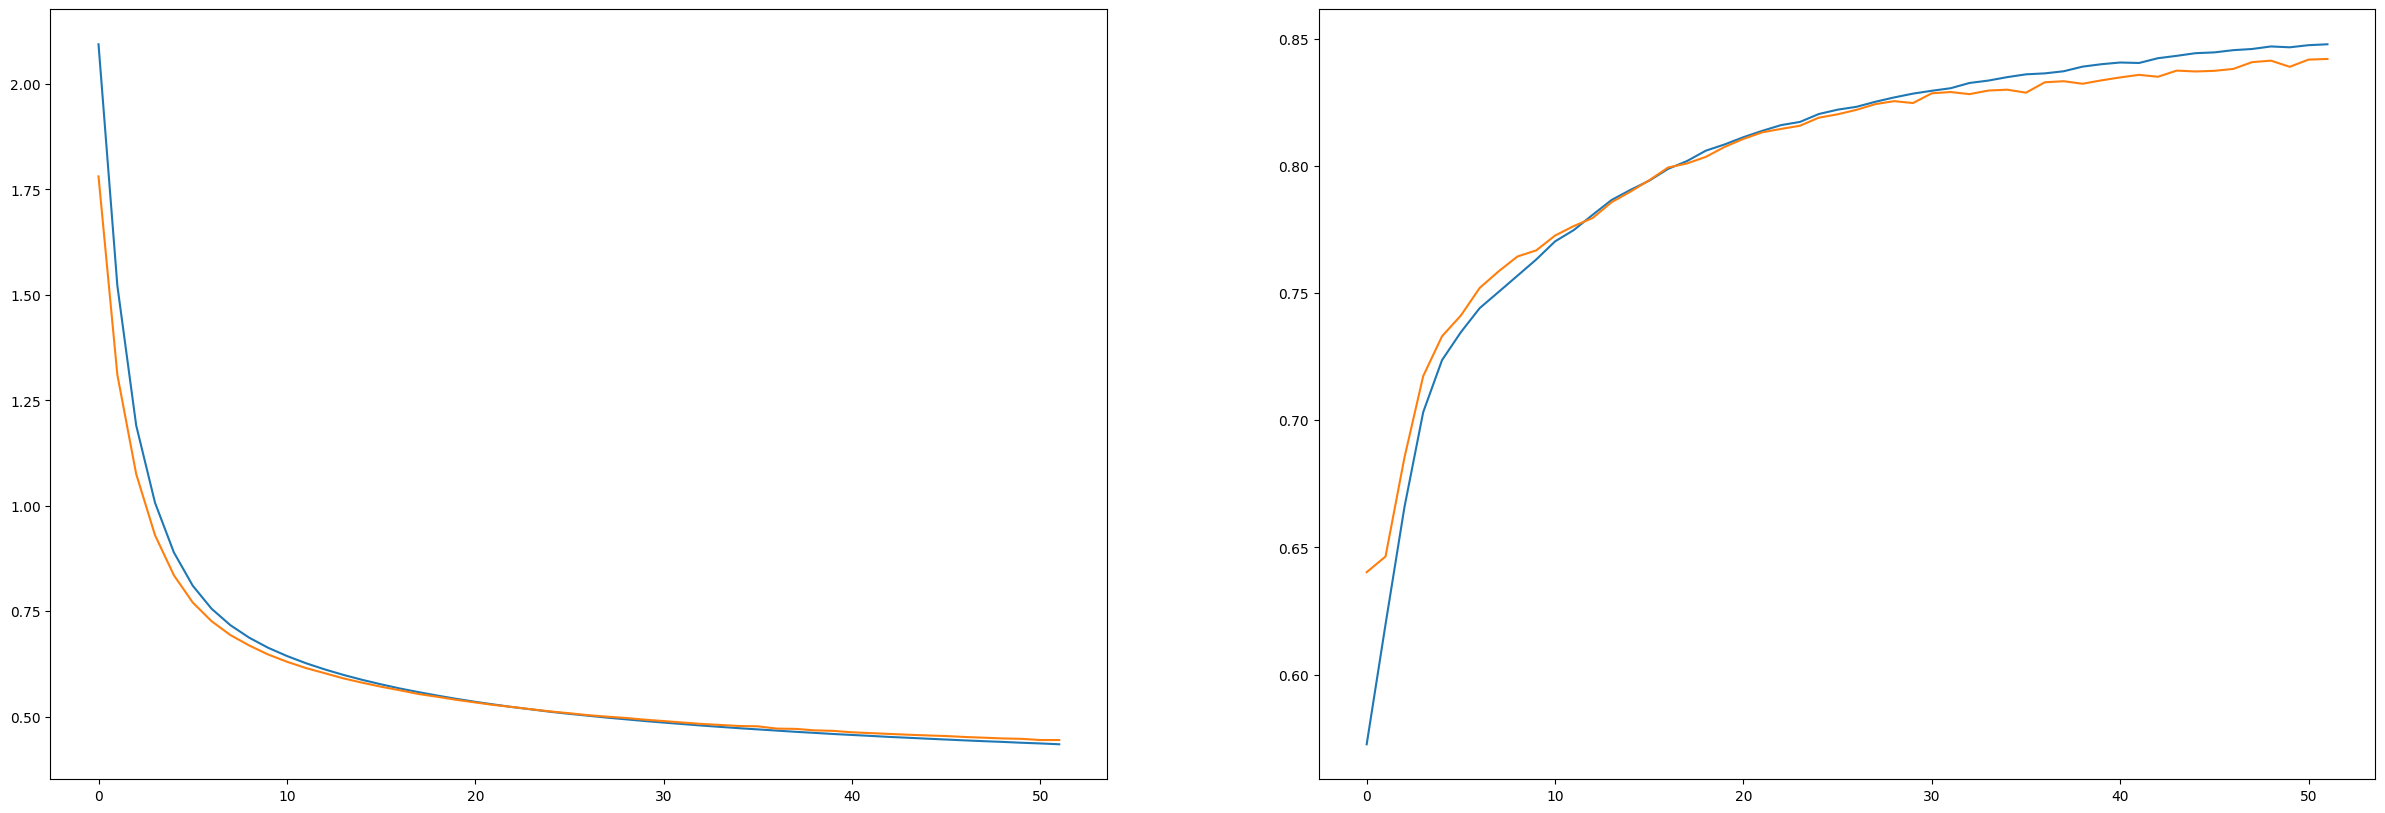

In [190]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.plot(model_two_layers.history.history['loss'])
ax1.plot(model_two_layers.history.history['val_loss'])
ax2.plot(model_two_layers.history.history['accuracy'])
ax2.plot(model_two_layers.history.history['val_accuracy'])

Let's add another hidden layer but this time using the Model class of keras

In [198]:
K.clear_session()
def three_layer_model(lr=0.001, decay=0, hidden_units_1=100, hidden_units_2=100, activation='relu', droupout1 = 0.25, droupout2 = 0.25):
    output_size = 10
    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(hidden_units_1, activation=activation, kernel_initializer='normal', name='middle_1'))
    model.add(Dropout(droupout1))
    model.add(Dense(hidden_units_2, activation=activation, kernel_initializer='normal', name='middle_2'))
    model.add(Dropout(droupout2))
    model.add(Dense(output_size, activation='softmax', kernel_initializer='normal', name='Output'))
    
    Adam = optimizers.Adam(learning_rate=lr, decay=decay)
    model.compile(loss = 'categorical_crossentropy', optimizer=Adam, metrics=['accuracy'])
    return model

model_three_layers = three_layer_model()

In [202]:
model_three_layers = three_layer_model(lr=0.001, hidden_units_1=500, hidden_units_2=50, activation='relu', droupout1 = 0.25, droupout2 = 0.10) 
model_three_layers.fit(x_train, 
          y_train_categorical ,
          epochs=500, batch_size=256, 
          verbose=2, 
          validation_data=(x_val, y_val_categorical),
          callbacks=[callback])

Epoch 1/500
188/188 - 4s - loss: 1.5719 - accuracy: 0.4514 - val_loss: 1.0095 - val_accuracy: 0.6058 - 4s/epoch - 22ms/step
Epoch 2/500
188/188 - 3s - loss: 0.9379 - accuracy: 0.6408 - val_loss: 0.7942 - val_accuracy: 0.7126 - 3s/epoch - 15ms/step
Epoch 3/500
188/188 - 3s - loss: 0.7881 - accuracy: 0.7099 - val_loss: 0.6876 - val_accuracy: 0.7413 - 3s/epoch - 16ms/step
Epoch 4/500
188/188 - 3s - loss: 0.6922 - accuracy: 0.7452 - val_loss: 0.6203 - val_accuracy: 0.7675 - 3s/epoch - 15ms/step
Epoch 5/500
188/188 - 3s - loss: 0.6415 - accuracy: 0.7641 - val_loss: 0.5863 - val_accuracy: 0.7875 - 3s/epoch - 15ms/step
Epoch 6/500
188/188 - 3s - loss: 0.6025 - accuracy: 0.7780 - val_loss: 0.5536 - val_accuracy: 0.7968 - 3s/epoch - 15ms/step
Epoch 7/500
188/188 - 3s - loss: 0.5742 - accuracy: 0.7924 - val_loss: 0.5329 - val_accuracy: 0.8059 - 3s/epoch - 15ms/step
Epoch 8/500
188/188 - 3s - loss: 0.5514 - accuracy: 0.8015 - val_loss: 0.5139 - val_accuracy: 0.8107 - 3s/epoch - 14ms/step
Epoch 9/

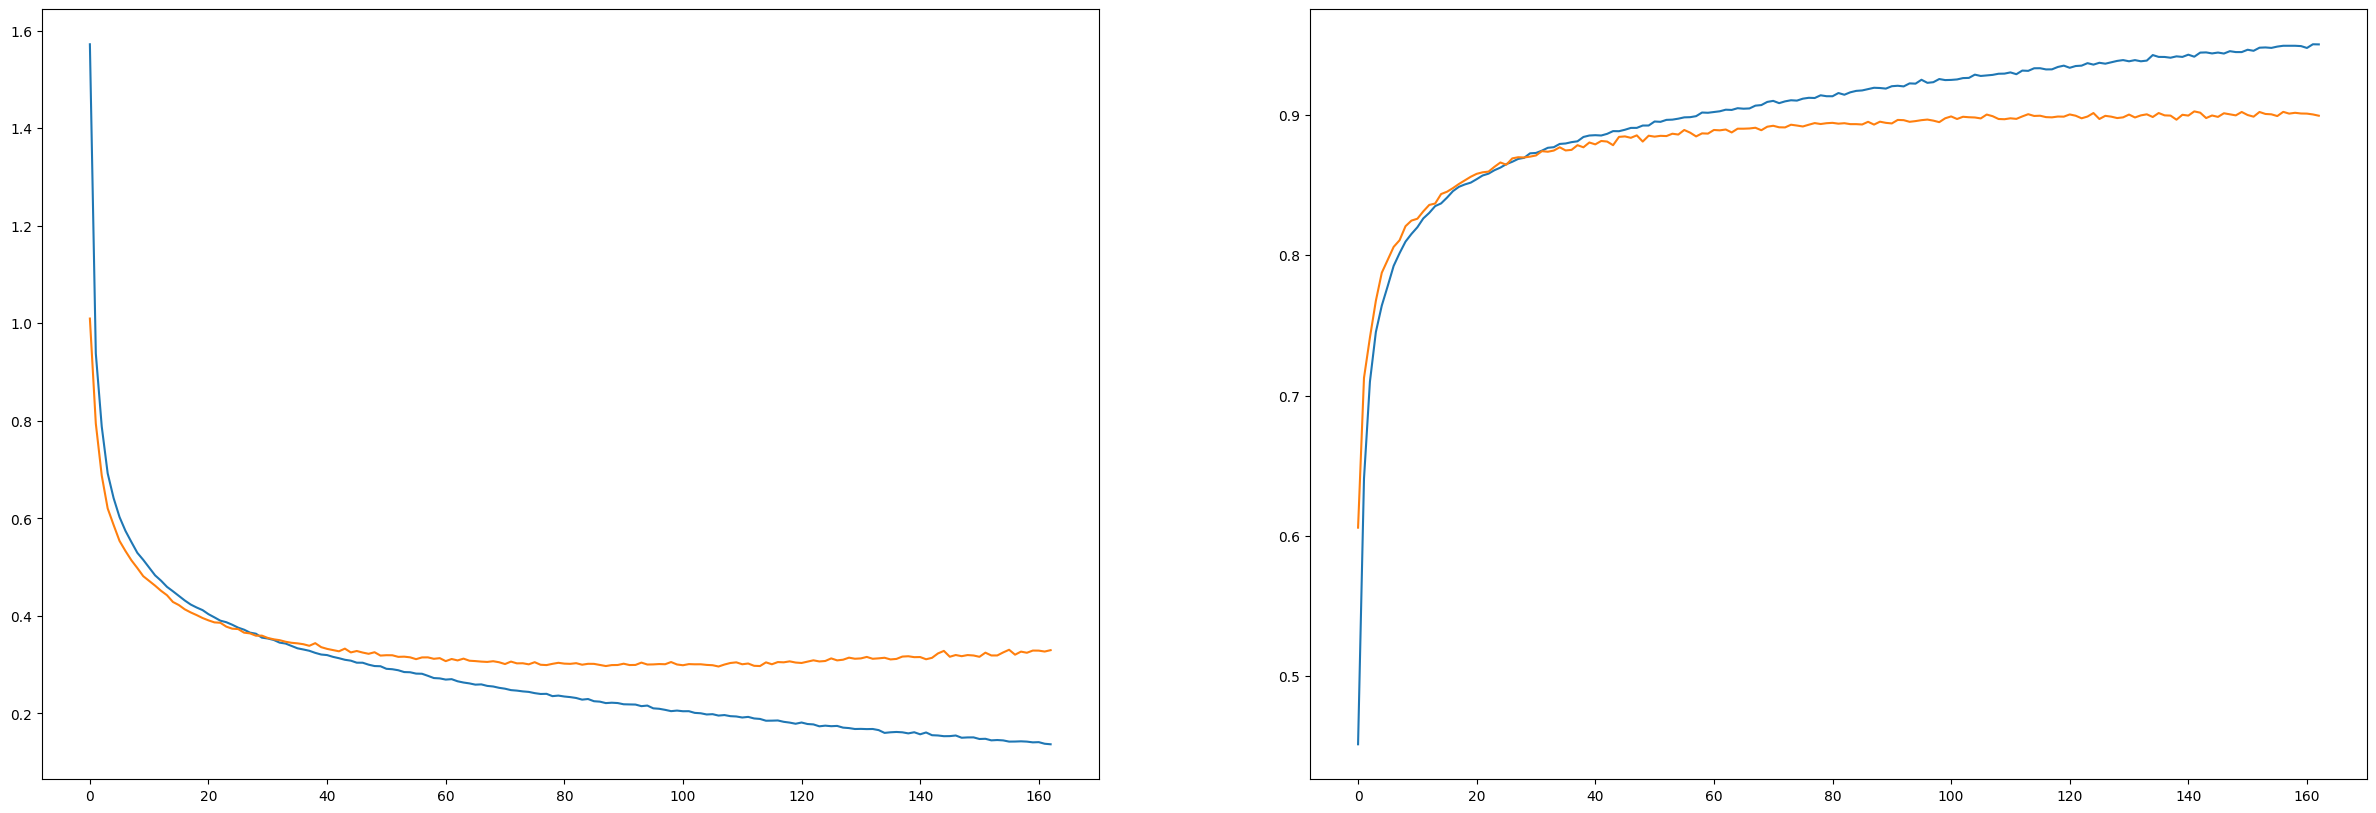

In [203]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.plot(model_three_layers.history.history['loss'])
ax1.plot(model_three_layers.history.history['val_loss'])
ax2.plot(model_three_layers.history.history['accuracy'])
ax2.plot(model_three_layers.history.history['val_accuracy'])

In [235]:
K.clear_session()
def four_layer_model(lr=0.001, decay=0, hidden_units_1=100, hidden_units_2=100, hidden_units_3 = 2, activation='relu', droupout1 = 0.25, droupout2 = 0.25, droupout3 = 0.25):
    output_size = 10
    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(hidden_units_1, activation=activation, kernel_initializer='normal', name='middle_1', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(droupout1))
    model.add(Dense(hidden_units_2, activation=activation, kernel_initializer='normal', name='middle_2', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(droupout2))
    model.add(Dense(hidden_units_3, activation=activation, kernel_initializer='normal', name='middle_3', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(droupout3))
    model.add(Dense(output_size, activation='sigmoid', kernel_initializer='normal', name='Output'))
    
    Adam = optimizers.Adam(learning_rate=lr, decay=decay)
    model.compile(loss = 'categorical_crossentropy', optimizer=Adam, metrics=['accuracy'])
    return model

model_four_layers = four_layer_model()

In [236]:
K.clear_session()
model_four_layers = four_layer_model(lr=0.001, hidden_units_1=500, hidden_units_2=250, hidden_units_3=50, activation='relu', droupout1 = 0.10, droupout2 = 0.10, droupout3 = 0.10) 
model_four_layers.summary()
model_four_layers.fit(x_train, 
          y_train_categorical ,
          epochs=500, batch_size=256, 
          verbose=2, 
          validation_data=(x_val, y_val_categorical),
          callbacks=[callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 middle_1 (Dense)            (None, 500)               392500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 middle_2 (Dense)            (None, 250)               125250    
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 middle_3 (Dense)            (None, 50)                12550     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0

KeyboardInterrupt: 

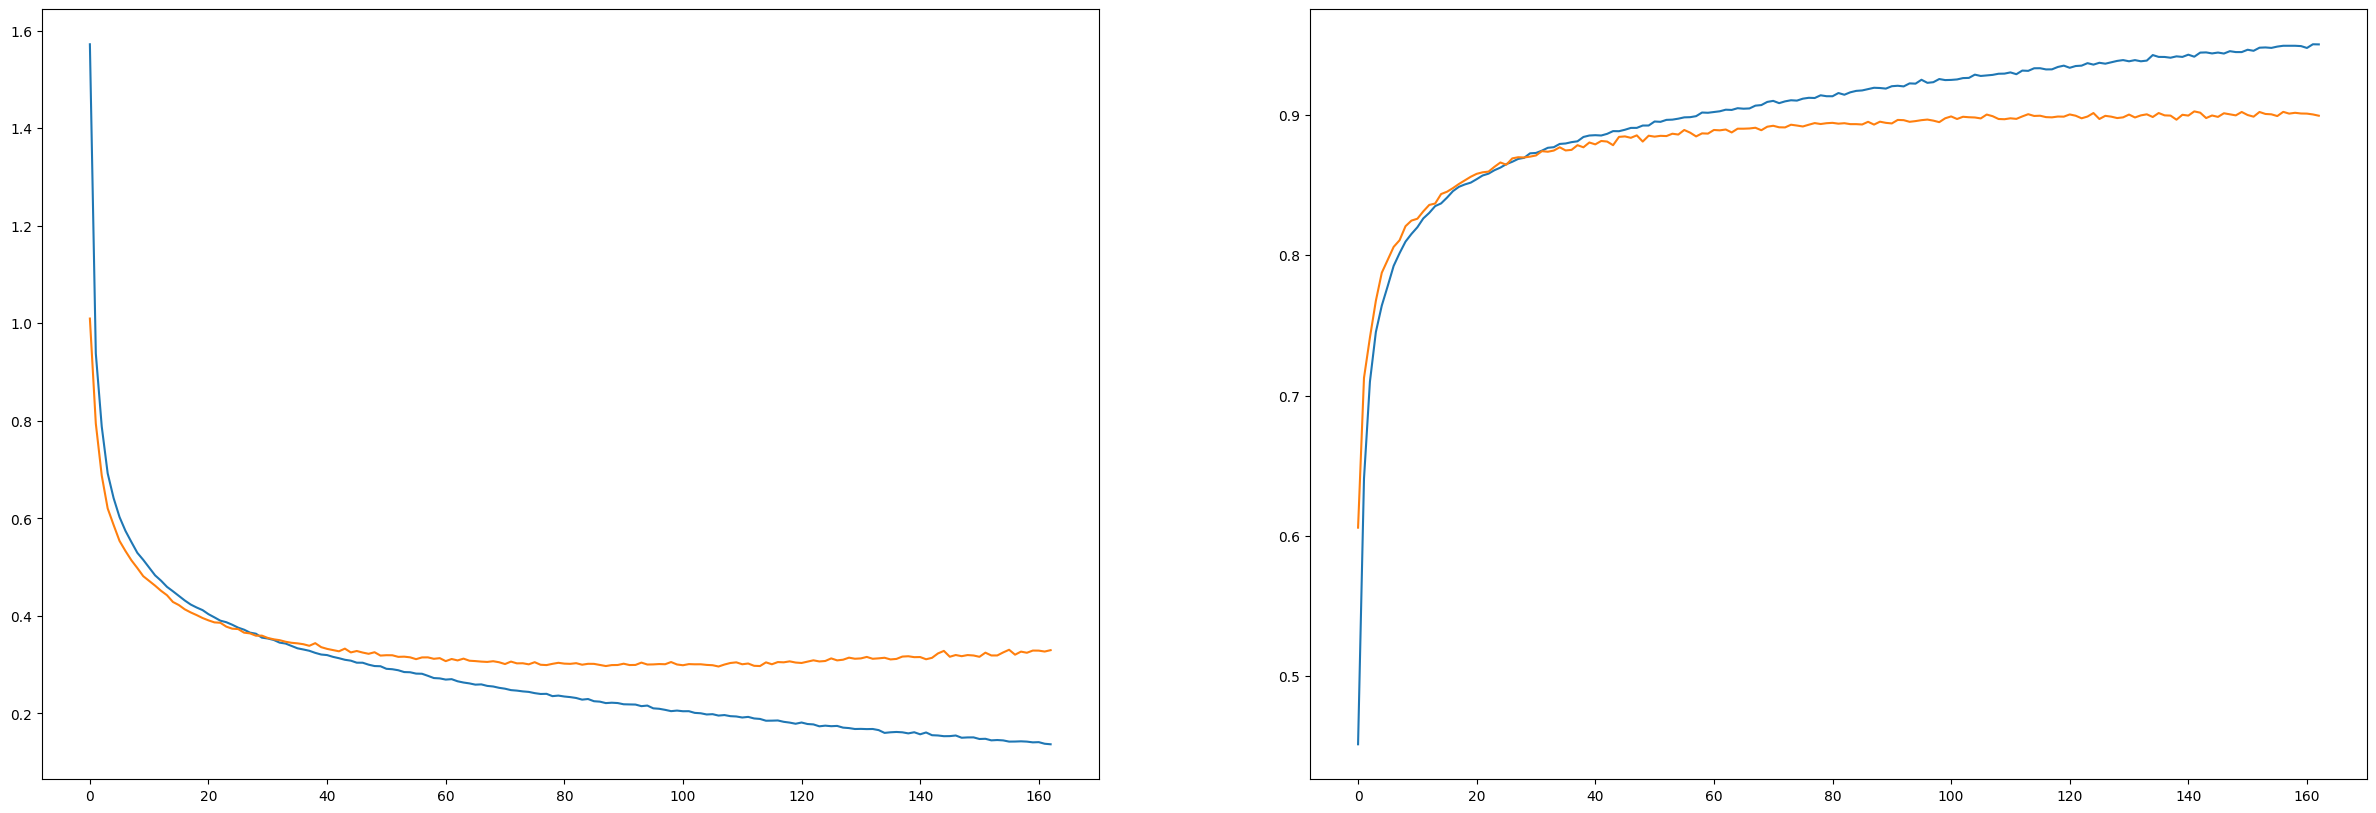

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.plot(model_four_layers.history.history['loss'])
ax1.plot(model_four_layers.history.history['val_loss'])
ax2.plot(model_four_layers.history.history['accuracy'])
ax2.plot(model_four_layers.history.history['val_accuracy'])

In [237]:
K.clear_session()
def five_layer_model(lr=0.001, decay=0, hidden_units_1=250, hidden_units_2=150, hidden_units_3 = 100, hidden_units_4 = 50, activation='relu', droupout1 = 0.25, droupout2 = 0.25, droupout3 = 0.25, droupout4 = 0.25):
    output_size = 10
    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(hidden_units_1, activation=activation, kernel_initializer='normal', name='middle_1'))
    model.add(Dropout(droupout1))
    model.add(Dense(hidden_units_2, activation=activation, kernel_initializer='normal', name='middle_2'))
    model.add(Dropout(droupout2))
    model.add(Dense(hidden_units_3, activation=activation, kernel_initializer='normal', name='middle_3'))
    model.add(Dropout(droupout3))
    model.add(Dense(hidden_units_4, activation=activation, kernel_initializer='normal', name='middle_4'))
    model.add(Dropout(droupout4))
    model.add(Dense(output_size, activation='sigmoid', kernel_initializer='normal', name='Output'))
    
    Adam = optimizers.Adam(learning_rate=lr, decay=decay)
    model.compile(loss = 'categorical_crossentropy', optimizer=Adam, metrics=['accuracy'])
    return model

model_five_layers = five_layer_model()

In [238]:
K.clear_session()
model_five_layers = five_layer_model(lr=0.001, hidden_units_1=500, hidden_units_2=250, hidden_units_3=150, hidden_units_4=50, activation='relu', droupout1 = 0.20, droupout2 = 0.20, droupout3 = 0.20, droupout4 = 0.20) 
model_five_layers.summary()
model_five_layers.fit(x_train, 
          y_train_categorical ,
          epochs=500, batch_size=128, 
          verbose=2, 
          validation_data=(x_val, y_val_categorical),
          callbacks=[callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 middle_1 (Dense)            (None, 250)               196250    
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 middle_2 (Dense)            (None, 150)               37650     
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 middle_3 (Dense)            (None, 100)               15100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0

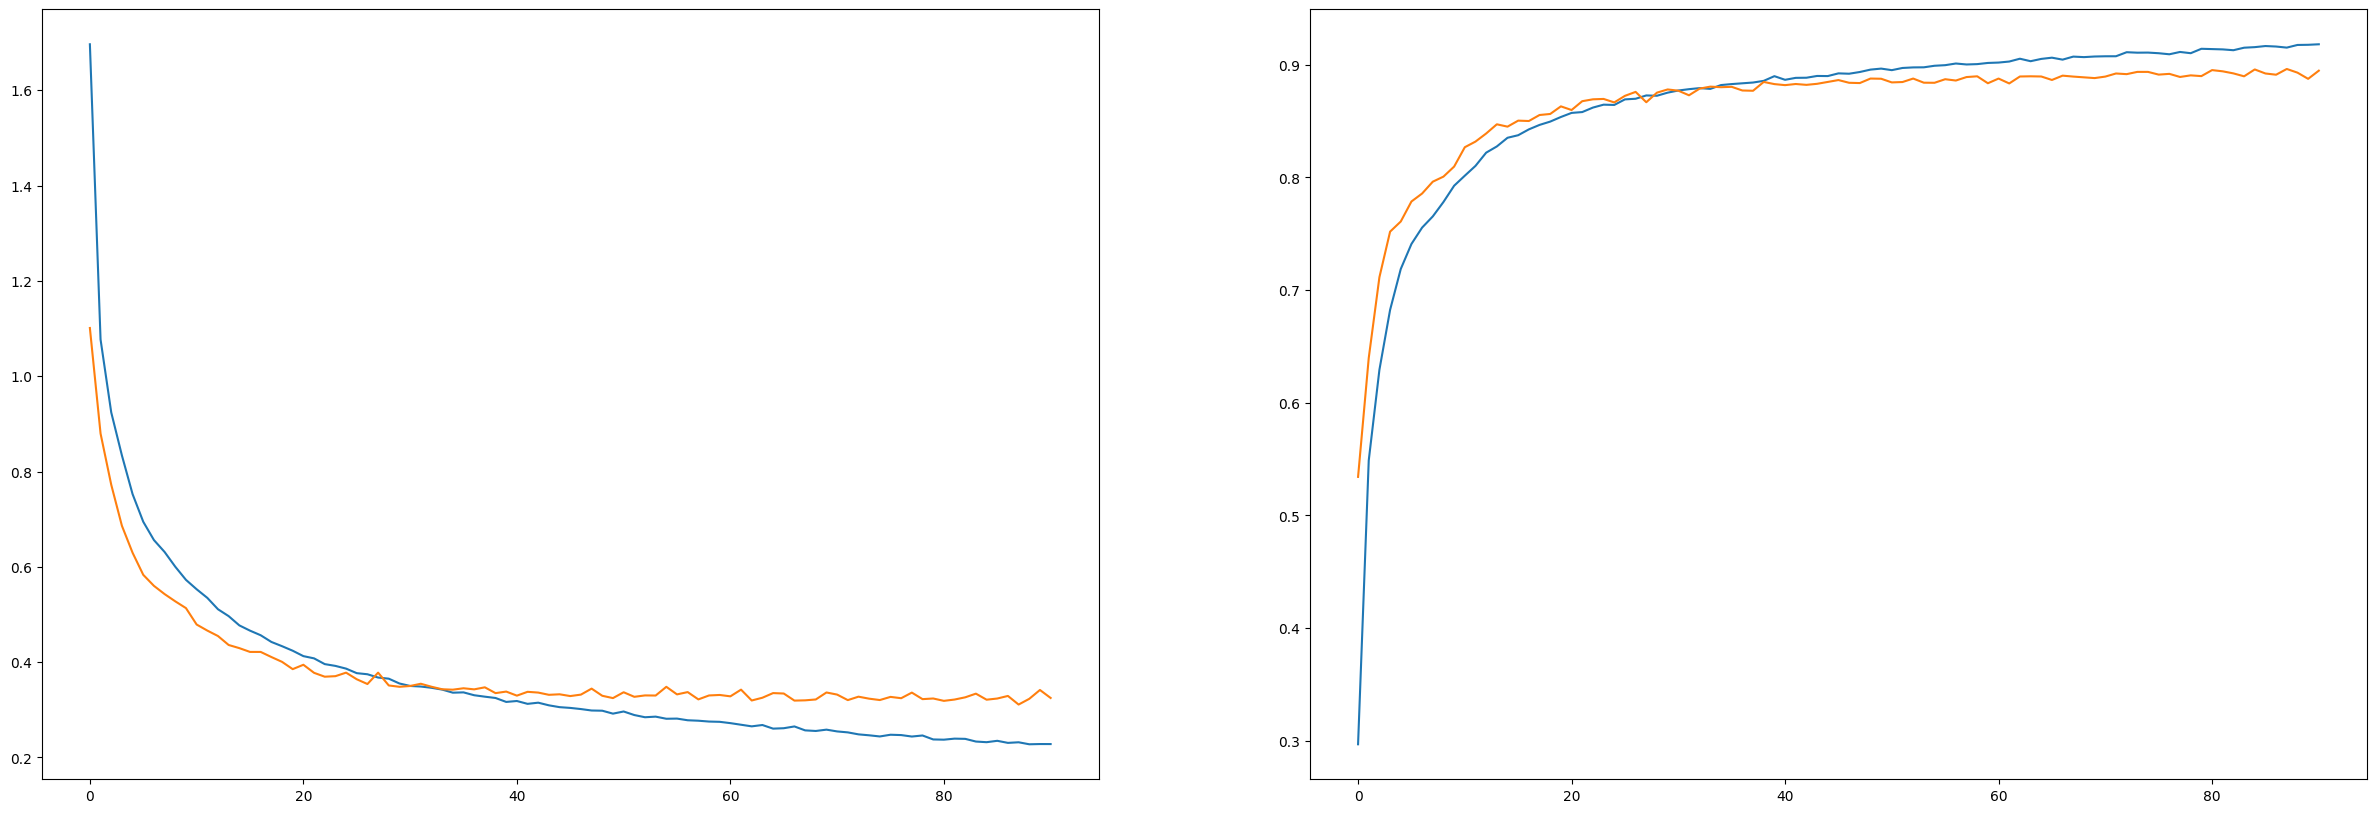

In [239]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.plot(model_five_layers.history.history['loss'])
ax1.plot(model_five_layers.history.history['val_loss'])
ax2.plot(model_five_layers.history.history['accuracy'])
ax2.plot(model_five_layers.history.history['val_accuracy'])

In [249]:
K.clear_session()
def six_layer_model(lr=0.001, decay=0, hidden_units_1=250, hidden_units_2=150, hidden_units_3 = 100, hidden_units_4 = 50, hidden_units_5 = 50, activation='relu', droupout1 = 0.25, droupout2 = 0.25, droupout3 = 0.25, droupout4 = 0.25, droupout5 = 0.25):
    output_size = 10
    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(hidden_units_1, activation=activation, kernel_initializer='normal', name='middle_1'))
    model.add(Dropout(droupout1))
    model.add(Dense(hidden_units_2, activation=activation, kernel_initializer='normal', name='middle_2'))
    model.add(Dropout(droupout2))
    model.add(Dense(hidden_units_3, activation=activation, kernel_initializer='normal', name='middle_3'))
    model.add(Dropout(droupout3))
    model.add(Dense(hidden_units_4, activation=activation, kernel_initializer='normal', name='middle_4'))
    model.add(Dropout(droupout4))
    model.add(Dense(hidden_units_5, activation=activation, kernel_initializer='normal', name='middle_5'))
    model.add(Dropout(droupout5))
    model.add(Dense(output_size, activation='sigmoid', kernel_initializer='normal', name='Output'))
    
    Adam = optimizers.Adam(learning_rate=lr, decay=decay)
    model.compile(loss = 'categorical_crossentropy', optimizer=Adam, metrics=['accuracy'])
    return model

model_six_layers = six_layer_model()

In [257]:
K.clear_session()
model_six_layers = six_layer_model(lr=0.001, hidden_units_1=1000, hidden_units_2=250, hidden_units_3=200, hidden_units_4=100, hidden_units_5=50, activation='relu', droupout1 = 0.20, droupout2 = 0.20, droupout3 = 0.20, droupout4 = 0.20, droupout5 = 0.20) 
model_six_layers.summary()
model_six_layers.fit(x_train, 
          y_train_categorical ,
          epochs=500, batch_size=128, 
          verbose=2, 
          validation_data=(x_val, y_val_categorical),
          callbacks=[callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 middle_1 (Dense)            (None, 1000)              785000    
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 middle_2 (Dense)            (None, 250)               250250    
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 middle_3 (Dense)            (None, 200)               50200     
                                                                 
 dropout_2 (Dropout)         (None, 200)               0

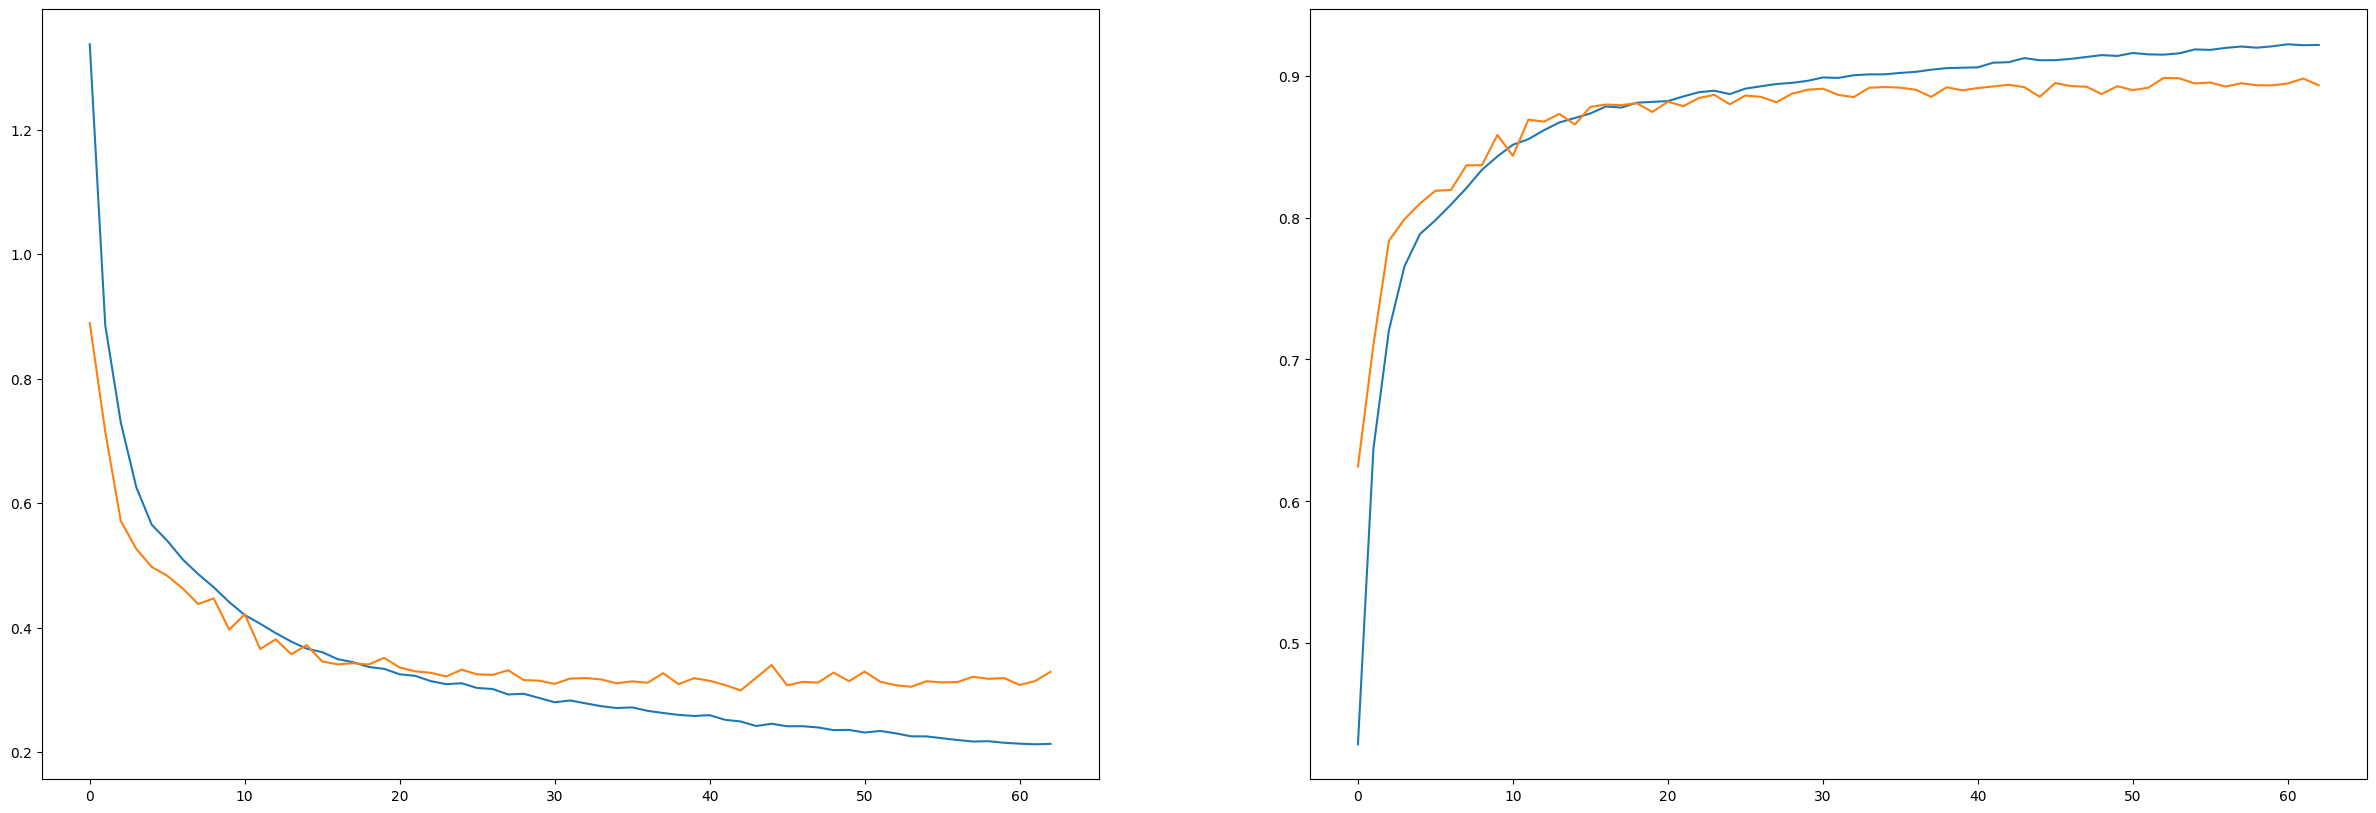

In [258]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.plot(model_six_layers.history.history['loss'])
ax1.plot(model_six_layers.history.history['val_loss'])
ax2.plot(model_six_layers.history.history['accuracy'])
ax2.plot(model_six_layers.history.history['val_accuracy'])